In [29]:
#Tarea 3 - Actividad 1

In [30]:
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from numba import jit, njit
from IPython.display import Image

In [31]:
#Creamos una simulación de Monte Carlo para un sistema bidimensional de partículas con un modelo de potencial de disco duro.

In [32]:
#Definimos la función para generar el estado inicial de la muestra aleatoria
def muestraInicial(nr, N):
    i = 0
    muestraX = []
    muestraY = []
    rad = 0.5
    L = np.sqrt(N/nr)/2 #Calculamos la longitud de la celda de tal modo que quede centrada
    while i < N:
        err = False
        x_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        y_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        if i == 0: #La primer coordenada simplemente la agregamos a la lista
            muestraX.append(x_n)
            muestraY.append(y_n)
            i = i + 1
        elif i > 0: #A partir de la segunda coordenada generada comenzamos a evaluar las distancias entre los puntos
            for j in range(len(muestraX)):
                dist = np.sqrt((x_n - muestraX[j])**2 + (y_n - muestraY[j])**2)
                if dist<2*rad: #Si la distancia es menor a dos veces el radio paramos la iteración e indicamos que hay un error con el valor generado 
                    err = True
                    break
                else:
                    continue
            if err == False: #Si no hay un error registrado entonces agregamos la coordenada generada a la lista
                muestraX.append(x_n)
                muestraY.append(y_n)
                i = i + 1
    return muestraX, muestraY

In [33]:
#Definimos la función que calcula el potencial total del sistema de partículas en su estado inicial
#Utilizaremos como argumentos el número de partículas, la longitud de la celda, el radio de corte, y los arreglos de posiciones
#de las partículas
@njit
def V_0(N, L, radC, x, y):
    V = 0
    i = 0
#Iniciamos un bule para seleccionar la partícula
    while i < N:
        xi = x[i]
        yi = y[i]
#Empezamos el bucle para calcular la distancia entre la partícula seleccionada y todas las demás
#se evalua si la distancia es mayor al radio de corte y se determina la aportación al potencial
        for j in range(i+1, N):
            xij = (xi - x[j])
            yij = (yi - y[j])
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = 1.0E+10
                else:
                    Vij = 0
                V = V + Vij
        i = i +1
    return V

In [34]:
#Definimos la función que calcula la energía potencial de la j-ésima partícula en el i-ésimo estado
#Utilizamos de argumentos el número de partículas, la longitud de la celda, los arreglos de posiciones
#en "x" y "y", las posiciones de la partícula de la cual se quiere saber el potencial,  
@njit
def V_j(N, L, radC, x, y, xj, yj, j):
    V = 0
    i = 0
    while i < N:
        if j != i:
            xij = xj - x[i]
            yij = yj - y[i]
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = 1.0E+10
                else:
                    Vij = 0
                V = V + Vij
        i = i + 1
    return V
#Esta función se utilizará dentro de la función de movimiento de las partículas

In [35]:
#Definimos la función de movimiento de las partículas
#Utilizamos como argumento los arreglos de las posiciones en "x" y "y", el número de partículas, la longitud de la celda,
#el número de estados, el radio de corte, la distancia máxima que pueden moverse las partículas, la frecuencia de corrección
#de paso, la frecuencia con la que se imprimen datos en pantalla, el criterio de correción, el potencial del estado inicial,
#la partícula trazadora y la corrección de largo alcance.
@njit
def movPart(x, y, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V, iTraza, Vlrc):
    numIter = 0 #Contador de iteraciones exitosas antes de cambiar el valor de la distancia máxima
    xTraza = np.zeros(nStep)
    yTraza = np.zeros(nStep)
#Abrimos un bucle para calcular el potencial de la j-ésima partícula en el i-ésimo estado con la función de potencial definida
#anteriormente, calcular la nueva posición, luego el nuevo potencial, y luego la diferencia de potencial entre estados
    for i in range(nStep):
        for j in range(N):
            x1 = x[j]
            y1 = y[j]
            V1 = V_j(N, L, radC, x, y, x1, y1, j)
            x2 = x1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            y2 = y1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            V2 = V_j(N, L, radC, x, y, x2, y2, j)
            x2 = x2 - L*round(x2/L) #Aplicamos condición de imagen mínima
            y2 = y2 - L*round(y2/L) #Aplicamos condición de imagen mínima
            dV = V2 - V1
#Abrimos un condicional que evalúe si el cambio de potencial es aceptable o no para saber si el cambio de posición lo es también
#y si se cumple sustituímos los valores existente en los arreglos de coordenadas por los nuevos 
            if dV < 75.:
                if dV <= 0.:
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    numIter = numIter + 1
                elif np.exp(-dV) > rd.uniform(0,1):
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    numIter = numIter + 1
#Un condicional que agrega las coordenadas de la j-ésima partícula a un arreglo de coordenadas de la partícula trazadora
            if j==iTraza:
                xTraza[i] = x[j]
                yTraza[i] = y[j]
#Se calcula el potencial del i-ésimo estado
        V_i = (V + Vlrc)/float(N)
#Se abre un condicional para revisar si es momento de cambiar el valor de la distancia máxima y si debe aumentar o disminuir
#según el criterio de correción
        if i % iRatio == 0:
            ratio = numIter/float((N*iRatio))
            if ratio > cc:
                drMax = drMax*1.05
            else:
                drMax = drMax*0.95
            numIter = 0.
#Si el número de iteraciones es algún múltiplo de la frecuencia de impresión entonces se imprimen los valores de la iteración,
#el ratio, la distancia máxima, y el potencial del i-ésimo estado.
        if i % iPrint == 0:
            print (i, ratio, drMax, V_i,"\n")
#La función regresa los arreglos de posiciones en "x" y "y", y las posiciones de la partícula trazadora
    return x, y, xTraza, yTraza

In [36]:
#Definimos los valores que utilizaremos
nStep = 10000 #Número de estados del sistema que se quieren simular
nFrec = 1000 #Frecuencia con la que se guardan los datos
Nener = 5000 #Iteración donde se alcanza equilibrio termodinámico
iPrint = 1000 #Frecuencia con la que se imprimen en pantalla los resultados
iRatio = 1000 #Frecuencia de correción de paso
cc = 0.5 #Criterio de corrección
drMax = 0.1 #Longitud de paso 

In [37]:
#(a) Concentración reducida fija en n*=0.4 y número de partículas N = 100, 500, 1000

In [38]:
#n* = 0.4 N = 100

In [39]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:100
Concentración reducida:0.4
Longitud de celda: 15.811388300841896 
Radio de corte: 7.905694150420948 


In [40]:
#Generamos la muestra aleatoria en su estado inicial, hacemos arreglos con las listas y hacemos un dataframe
muestraX, muestraY = muestraInicial(nr, N)
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestra0_100 = {'x_0': muestraX, 'y_0': muestraY} 
df0_100 = pd.DataFrame(muestra0_100)

In [41]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 0.0

In [42]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 22

In [43]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_100 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_100 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_100 = pd.DataFrame(muestraF_100)
dfT_100 = pd.DataFrame(traza_100)

0 0.00091 0.095 0.0 

1000 0.89848 0.09975 0.0 

2000 0.88986 0.10473750000000001 0.0 

3000 0.88754 0.10997437500000001 0.0 

4000 0.88402 0.11547309375000002 0.0 

5000 0.88017 0.12124674843750002 0.0 

6000 0.87866 0.12730908585937503 0.0 

7000 0.86512 0.13367454015234378 0.0 

8000 0.85658 0.14035826715996097 0.0 

9000 0.85858 0.14737618051795903 0.0 



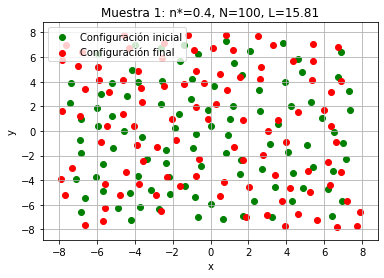

In [44]:
#Graficamos el resultado con n*=0.4 y N=100
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df0_100['x_0'], df0_100['y_0'], c = 'g', label = 'Configuración inicial')
ax1.scatter(df1_100['x_f'], df1_100['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 1: n*=0.4, N=100, L=15.81')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [45]:
#n* = 0.4 N = 500

In [46]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:500
Concentración reducida:0.4
Longitud de celda: 35.35533905932738 
Radio de corte: 17.67766952966369 


In [49]:
#Generamos la muestra aleatoria en su estado inicial y la ponemos en un dataframe
muestraX, muestraY = muestraInicial(nr, N) 
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestra0_500 = {'x_0': muestraX, 'y_0': muestraY} 
df0_500 = pd.DataFrame(muestra0_500)

In [53]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 0.0

In [54]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 438

In [55]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_500 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_500 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_500 = pd.DataFrame(muestraF_500)
dfT_500 = pd.DataFrame(traza_500)

0 0.000898 0.095 0.0 

1000 0.899086 0.09975 0.0 

2000 0.891652 0.10473750000000001 0.0 

3000 0.888718 0.10997437500000001 0.0 

4000 0.886374 0.11547309375000002 0.0 

5000 0.881424 0.12124674843750002 0.0 

6000 0.873936 0.12730908585937503 0.0 

7000 0.867368 0.13367454015234378 0.0 

8000 0.85996 0.14035826715996097 0.0 

9000 0.856746 0.14737618051795903 0.0 



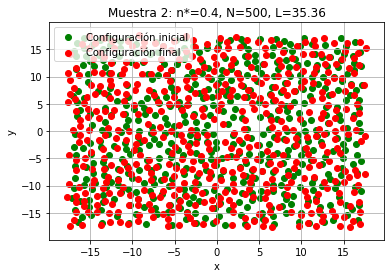

In [56]:
#Graficamos el resultado con n*=0.4 y N=500
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.scatter(df0_500['x_0'], df0_500['y_0'], c = 'g', label = 'Configuración inicial')
ax2.scatter(df1_500['x_f'], df1_500['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 2: n*=0.4, N=500, L=35.36')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [57]:
#n* = 0.4 N = 1000

In [58]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:1000
Concentración reducida:0.4
Longitud de celda: 50.0 
Radio de corte: 25.0 


In [59]:
#Generamos la muestra aleatoria en su estado inicial y la ponemos en un dataframe
muestraX, muestraY = muestraInicial(nr, N) 
muestra0_1000 = {'x_0': muestraX, 'y_0': muestraY}
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
df0_1000 = pd.DataFrame(muestra0_1000)

In [60]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 0.0

In [61]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 616

In [62]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_1000 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_1000 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_1000 = pd.DataFrame(muestraF_1000)
dfT_1000 = pd.DataFrame(traza_1000)

0 0.000908 0.095 0.0 

1000 0.901081 0.09975 0.0 

2000 0.895883 0.10473750000000001 0.0 

3000 0.890953 0.10997437500000001 0.0 

4000 0.883182 0.11547309375000002 0.0 

5000 0.881618 0.12124674843750002 0.0 

6000 0.875819 0.12730908585937503 0.0 

7000 0.869013 0.13367454015234378 0.0 

8000 0.863757 0.14035826715996097 0.0 

9000 0.856303 0.14737618051795903 0.0 



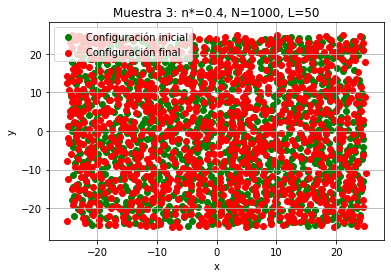

In [63]:
#Graficamos el resultado con n*=0.4 y N=1000
fig = plt.figure()
ax3 = fig.add_subplot(111)

ax3.scatter(df0_1000['x_0'], df0_1000['y_0'], c = 'g', label = 'Configuración inicial')
ax3.scatter(df1_1000['x_f'], df1_1000['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 3: n*=0.4, N=1000, L=50')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [64]:
#(b) Concentración reducida en n*=0.2, 0.6, 0.8 y número de partículas fijo en N = 500

In [65]:
#n* = 0.2 N = 500

In [66]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:500
Concentración reducida:0.2
Longitud de celda: 50.0 
Radio de corte: 25.0 


In [67]:
#Generamos la muestra aleatoria en su estado inicial y la ponemos en un dataframe
muestraX, muestraY = muestraInicial(nr, N) 
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestra0_02 = {'x_0': muestraX, 'y_0': muestraY} 
df0_02 = pd.DataFrame(muestra0_02)

In [68]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 0.0

In [69]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 321

In [70]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_02 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_02 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_02 = pd.DataFrame(muestraF_02)
dfT_02 = pd.DataFrame(traza_02)

0 0.000972 0.095 0.0 

1000 0.962608 0.09975 0.0 

2000 0.960566 0.10473750000000001 0.0 

3000 0.959272 0.10997437500000001 0.0 

4000 0.958782 0.11547309375000002 0.0 

5000 0.955578 0.12124674843750002 0.0 

6000 0.95139 0.12730908585937503 0.0 

7000 0.947278 0.13367454015234378 0.0 

8000 0.946792 0.14035826715996097 0.0 

9000 0.946614 0.14737618051795903 0.0 



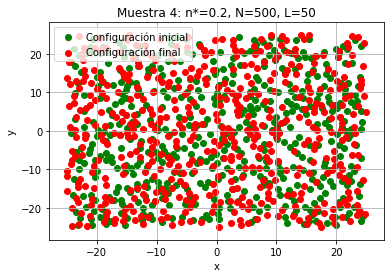

In [72]:
#Graficamos el resultado con n*=0.2 y N=500
fig = plt.figure()
ax4 = fig.add_subplot(111)

ax4.scatter(df0_02['x_0'], df0_02['y_0'], c = 'g', label = 'Configuración inicial')
ax4.scatter(df1_02['x_f'], df1_02['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 4: n*=0.2, N=500, L=50')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [73]:
#n* = 0.6 N = 500

In [74]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:500
Concentración reducida:0.6
Longitud de celda: 28.867513459481287 
Radio de corte: 14.433756729740644 


In [75]:
#Generamos la muestra aleatoria en su estado inicial y la ponemos en un dataframe
muestraX, muestraY = muestraInicial(nr, N) 
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestra0_06 = {'x_0': muestraX, 'y_0': muestraY} 
df0_06 = pd.DataFrame(muestra0_06)

In [76]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 0.0

In [77]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 177

In [78]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_06 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_06 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_06 = pd.DataFrame(muestraF_06)
dfT_06 = pd.DataFrame(traza_06)

0 0.00079 0.095 0.0 

1000 0.782918 0.09975 0.0 

2000 0.77402 0.10473750000000001 0.0 

3000 0.767328 0.10997437500000001 0.0 

4000 0.752992 0.11547309375000002 0.0 

5000 0.746458 0.12124674843750002 0.0 

6000 0.736976 0.12730908585937503 0.0 

7000 0.725496 0.13367454015234378 0.0 

8000 0.711274 0.14035826715996097 0.0 

9000 0.701242 0.14737618051795903 0.0 



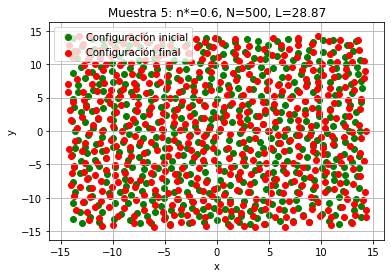

In [79]:
#Graficamos el resultado con n*=0.6 y N=500
fig = plt.figure()
ax5 = fig.add_subplot(111)

ax5.scatter(df0_06['x_0'], df0_06['y_0'], c = 'g', label = 'Configuración inicial')
ax5.scatter(df1_06['x_f'], df1_06['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 5: n*=0.6, N=500, L=28.87')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [80]:
#n* = 0.8 N = 500

In [81]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = np.sqrt(N/nr)
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:500
Concentración reducida:0.8
Longitud de celda: 25.0 
Radio de corte: 12.5 


In [82]:
#Generamos la muestra aleatoria en su estado inicial y la ponemos en un dataframe
muestraX, muestraY = muestraInicial(nr, N) 
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestra0_08 = {'x_0': muestraX, 'y_0': muestraY} 
df0_08 = pd.DataFrame(muestra0_08)

KeyboardInterrupt: 

Para la concentración reducida n* = 0.8 no fue posible encontrar la configuración inicial.

In [83]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 2980000000000.0

In [84]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 75

In [ ]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, xTraza, yTraza = movPart(muestraX, muestraY, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc)
muestraF_08 = {'x_f': muestraFx, 'y_f': muestraFy} #Creamos lista de listas para las posiciones finales
traza_08 = {'x': xTraza, 'y': yTraza} #Creamos lista de listas para las posiciones de la traza
df1_08 = pd.DataFrame(muestraF_08)
dfT_08 = pd.DataFrame(traza_08)

In [ ]:
#Graficamos el resultado con n*=0.4 y N=100
fig = plt.figure()
ax6 = fig.add_subplot(111)

ax6.scatter(df0_08['x_0'], df0_08['y_0'], c = 'g', label = 'Configuración inicial')
ax6.scatter(df1_08['x_f'], df1_08['y_f'], c = 'r', label = 'Configuración final')
plt.grid()
plt.title('Muestra 6: n*=0.8, N=500, L=25')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()